In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path=r'D:/模式识别/自我监测系统项目/TestData.xml'

In [3]:
tree=ET.parse(path)
root=tree.getroot()

In [4]:
df=pd.DataFrame([list.attrib for list in root.findall('Record')])

In [5]:
print(f"表格大小{df.shape}")
print(f"列名{df.columns}")
print(f"行名{df.index}")
print(f"type:{df['type'].unique()}")

表格大小(20520, 9)
列名Index(['type', 'sourceName', 'sourceVersion', 'unit', 'creationDate',
       'startDate', 'endDate', 'value', 'device'],
      dtype='object')
行名RangeIndex(start=0, stop=20520, step=1)
type:['HKQuantityTypeIdentifierHeight' 'HKQuantityTypeIdentifierBodyMass'
 'HKQuantityTypeIdentifierHeartRate'
 'HKQuantityTypeIdentifierOxygenSaturation'
 'HKQuantityTypeIdentifierRespiratoryRate'
 'HKQuantityTypeIdentifierStepCount'
 'HKQuantityTypeIdentifierDistanceWalkingRunning'
 'HKQuantityTypeIdentifierBasalEnergyBurned'
 'HKQuantityTypeIdentifierActiveEnergyBurned'
 'HKQuantityTypeIdentifierFlightsClimbed'
 'HKQuantityTypeIdentifierAppleExerciseTime'
 'HKQuantityTypeIdentifierRestingHeartRate'
 'HKQuantityTypeIdentifierWalkingHeartRateAverage'
 'HKQuantityTypeIdentifierEnvironmentalAudioExposure'
 'HKQuantityTypeIdentifierHeadphoneAudioExposure'
 'HKQuantityTypeIdentifierWalkingDoubleSupportPercentage'
 'HKQuantityTypeIdentifierAppleStandTime'
 'HKQuantityTypeIdentifierWalkingSpe

In [6]:
#将由xml转成Dataframe的value列里面原本是字符串格式转换为python对象(python能识别为时间的东西）
df['startDate']=pd.to_datetime(df['startDate'])
df['endDate']=pd.to_datetime(df['endDate'])
#切出我有用备忘录记录下来当前状态的时间段
start_time=pd.to_datetime('2026-02-08 00:38:00+0800')
end_time = pd.to_datetime('2026-02-09 15:20:00+0800')
mask=(df['startDate']>=start_time)&(df['endDate']<=end_time)
RecordDF=df.loc[mask].copy()

#把value列从字符串转为数字,第二个参数意思为遇到转不动的就变为空局NaN
RecordDF['value']=pd.to_numeric(RecordDF['value'],errors='coerce')

# 顺手删掉转换后产生的空值，保证绘图连续性
RecordDF = RecordDF.dropna(subset=['value'])

#选择要观察的信号列表
target_signals={
    'HRV': 'HKQuantityTypeIdentifierHeartRateVariabilitySDNN',
    'HR': 'HKQuantityTypeIdentifierHeartRate',
    'Respiratory': 'HKQuantityTypeIdentifierRespiratoryRate',
    'Oxygen': 'HKQuantityTypeIdentifierOxygenSaturation',
    'Audio': 'HKQuantityTypeIdentifierEnvironmentalAudioExposure'
}
print(f"切出成功")

切出成功


In [7]:
#Test
# 看看整张大表里，最早和最晚的一条记录分别是什么时候（确定没有传感器记录问题）
print("数据文件中实际包含的时间范围：")
print(f"起点: {df['startDate'].min()}")
print(f"终点: {df['startDate'].max()}")

数据文件中实际包含的时间范围：
起点: 2025-10-15 12:00:00+08:00
终点: 2026-02-10 16:29:49+08:00


In [8]:
#时区转换
import pandas as pd

# 1. 彻底重新处理时间（确保干净）
df['startDate'] = pd.to_datetime(df['startDate'], utc=True).dt.tz_convert('Asia/Shanghai').dt.tz_localize(None)

# 2. 设置窗口
start_time = pd.to_datetime('2026-02-08 00:38:00')
end_time = pd.to_datetime('2026-02-09 15:20:00')

# 3. 优化后的筛选：只管开始时间在范围内就行
# 这样能防止因为 endDate 稍微超了一点点就被整行排除的情况
mask = (df['startDate'] >= start_time) & (df['startDate'] <= end_time)

# 4. 生成结果
RecordDF = df.loc[mask].copy()

#转换成数字
RecordDF['value'] = pd.to_numeric(RecordDF['value'], errors='coerce')
RecordDF = RecordDF.dropna(subset=['value'])

print(f"目标区间筛选出的行数: {len(RecordDF)}")
if not RecordDF.empty:
    print(f"筛选后的实际终点: {RecordDF['startDate'].max()}")

目标区间筛选出的行数: 1207
筛选后的实际终点: 2026-02-09 14:30:58


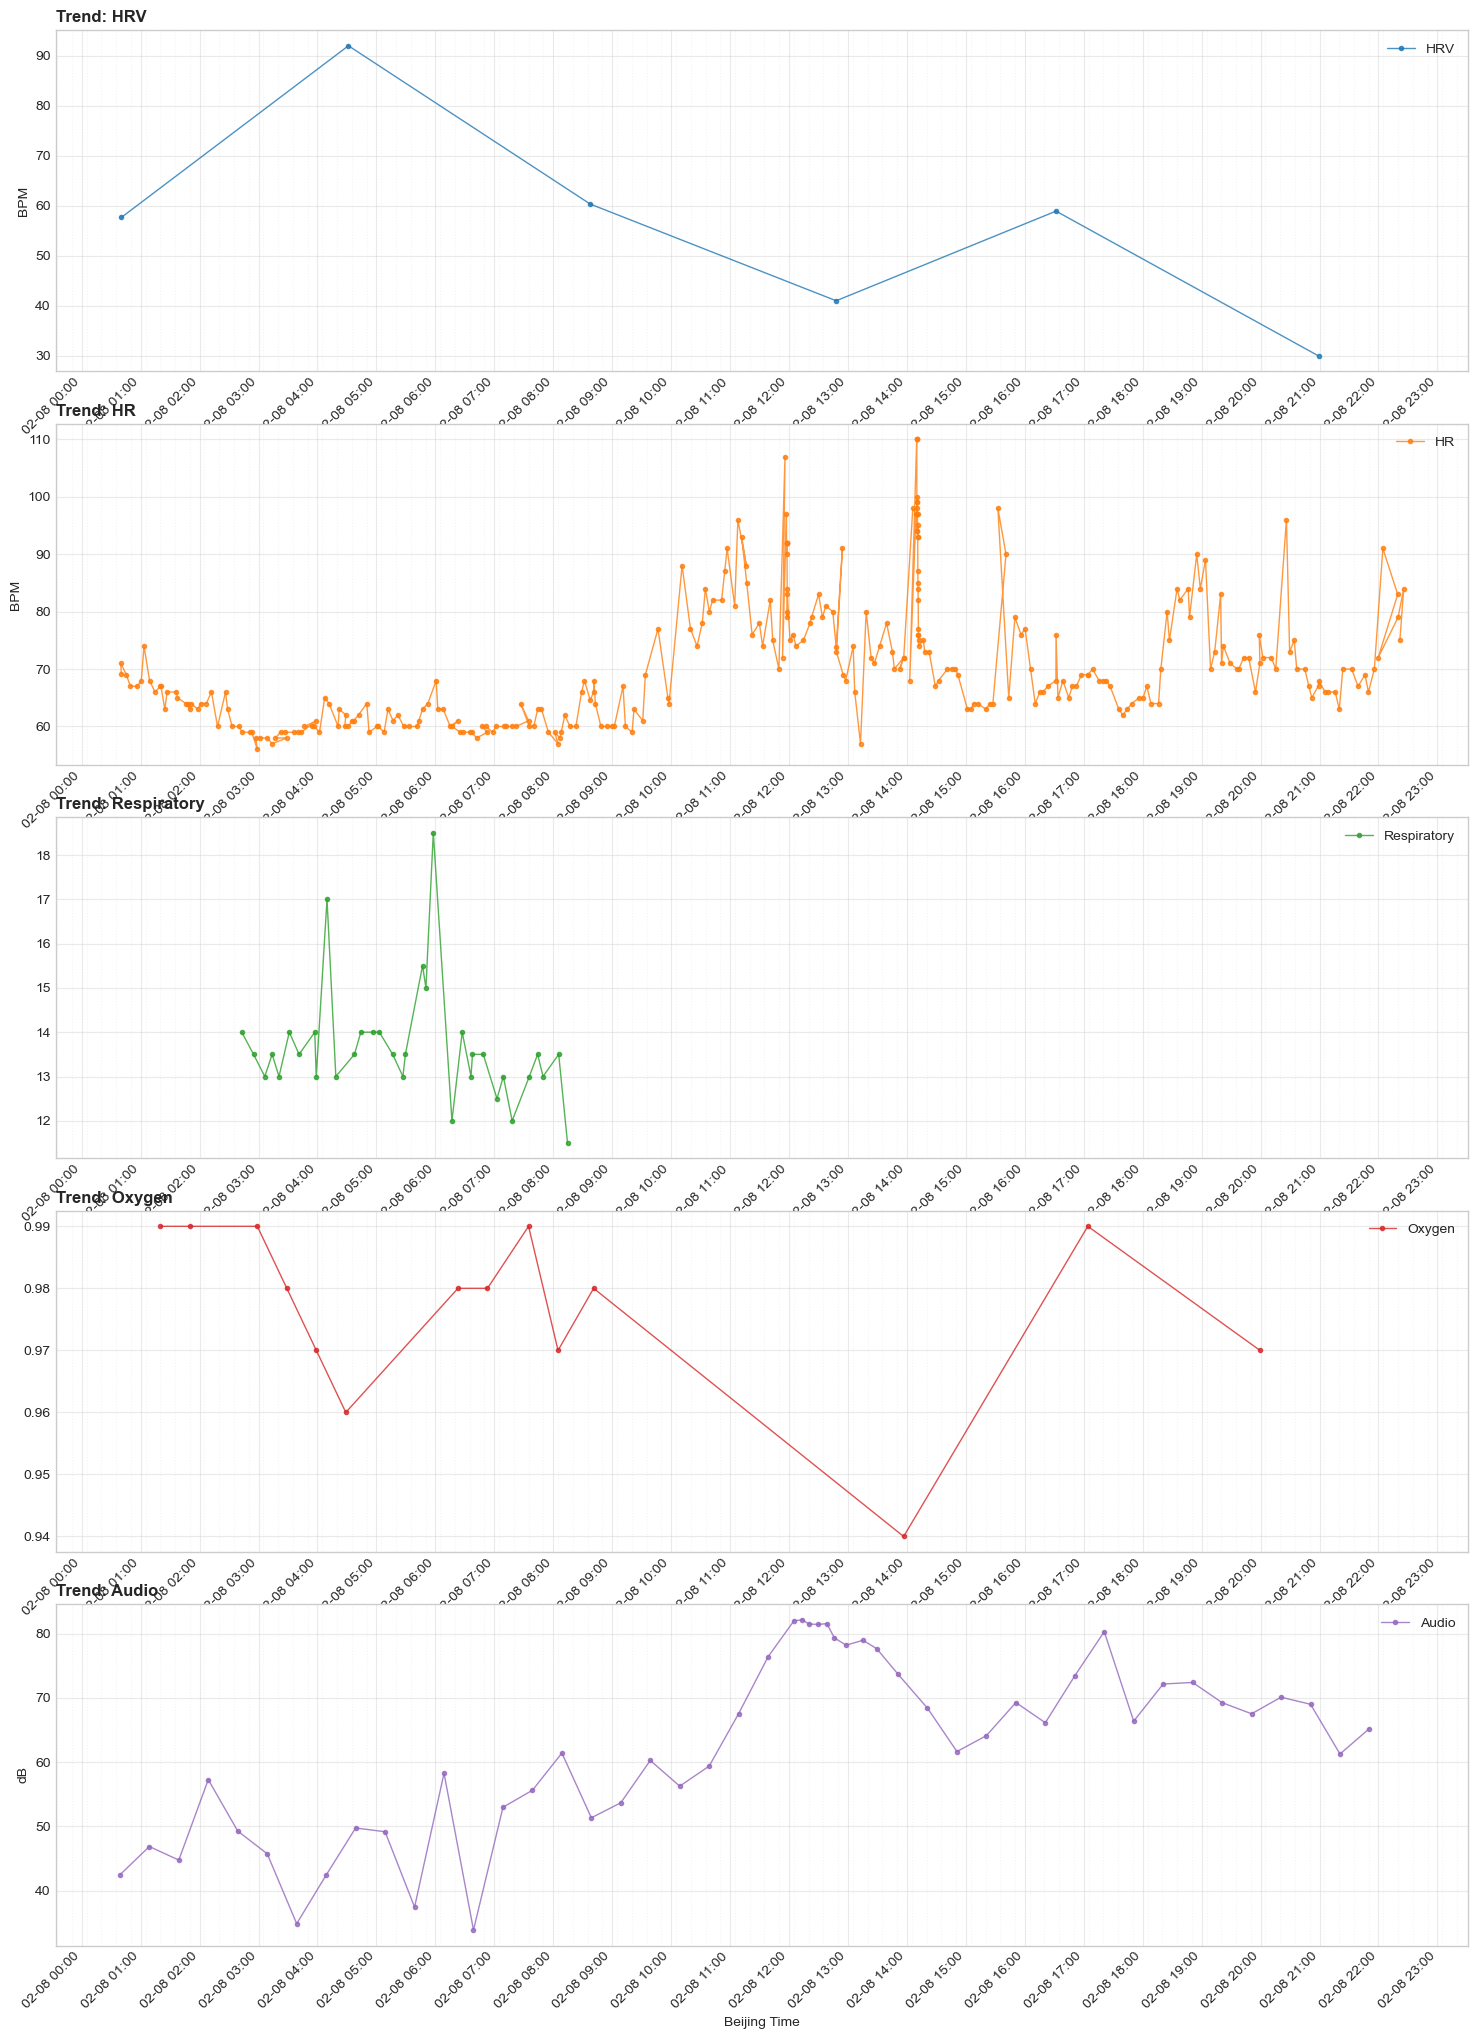

In [9]:
#画图
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# 1. 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')

# 2. 确定有哪些信号在数据中是真实存在的
# 只为有数据的指标画图，避免出现空白窗口
available_signals = {
    label: iden for label, iden in target_signals.items() 
    if not RecordDF[RecordDF['type'] == iden].empty
}

num_charts = len(available_signals)

if num_charts == 0:
    print("当前筛选的时间范围内没有找到匹配的信号数据。")
else:
    # 3. 创建画布：sharex=True 保证所有子图时间轴垂直对齐
    fig, axes = plt.subplots(num_charts, 1, figsize=(15, 4 * num_charts), sharex=True)
    
    # 确保 axes 始终是列表（即使只有一个图）
    if num_charts == 1: axes = [axes]

    for i, (label, identifier) in enumerate(available_signals.items()):
        ax = axes[i]
        subset = RecordDF[RecordDF['type'] == identifier].copy()
        
        # 绘图：'o-' 表示有点有线，alpha=0.7 增加透明度防止重叠
        ax.plot(subset['startDate'], subset['value'], 'o-', 
                markersize=3, linewidth=1, label=label, color=f'C{i}', alpha=0.8)
        
 
        # 设置网格线
        ax.grid(True, which='major', linestyle='-', alpha=0.4)
        ax.grid(True, which='minor', linestyle=':', alpha=0.2)
        
        # 设置标题和图例
        ax.set_title(f'Trend: {label}', fontsize=12, loc='left', fontweight='bold')
        ax.legend(loc='upper right')
        
        # 针对不同指标的单位标注
        if 'HeartRate' in identifier: ax.set_ylabel('BPM')
        elif 'Variability' in identifier: ax.set_ylabel('ms (SDNN)')
        elif 'Audio' in identifier: ax.set_ylabel('dB')
            
         # --- 坐标轴细致度优化 ---
        
        ax.tick_params(axis='x', which='both', labelbottom=True)   
        # 主刻度：每 1 小时
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))

        # 次刻度：每 15 分钟
        ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))

        # 时间显示格式（
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        
    # 4. 
    plt.xlabel('Beijing Time')
    plt.tight_layout()
    
    for ax in axes:
        plt.sca(ax)
        plt.xticks(rotation=45, ha='right')

    plt.show()